In [1]:
from google.colab import auth
auth.authenticate_user()
project_id = 'neat-library-245005'
!gcloud config set project {project_id}
bucket_name = 'nlp_bucked'

!gsutil -m cp -r gs://nlp_bucked/out_data ~/
!gsutil cp gs://nlp_bucked/* .

Updated property [core/project].
Copying gs://nlp_bucked/out_data/.DS_Store...
Copying gs://nlp_bucked/out_data/test/.DS_Store...
Copying gs://nlp_bucked/out_data/test/test.csv...
Copying gs://nlp_bucked/out_data/train/.DS_Store...
Copying gs://nlp_bucked/out_data/train/train.csv...
- [5/5 files][  7.8 MiB/  7.8 MiB] 100% Done                                    
Operation completed over 5 objects/7.8 MiB.                                      
Omitting prefix "gs://nlp_bucked/bert-tfhub/". (Did you mean to do cp -r?)
Omitting prefix "gs://nlp_bucked/out_data/". (Did you mean to do cp -r?)
CommandException: No URLs matched


In [2]:
!gsutil cp gs://nlp_bucked/out_data/train/train.csv .
!gsutil cp gs://nlp_bucked/out_data/test/test.csv .

Copying gs://nlp_bucked/out_data/train/train.csv...
- [1 files][  4.6 MiB/  4.6 MiB]                                                
Operation completed over 1 objects/4.6 MiB.                                      
Copying gs://nlp_bucked/out_data/test/test.csv...
- [1 files][  3.3 MiB/  3.3 MiB]                                                
Operation completed over 1 objects/3.3 MiB.                                      


In [3]:
!ls ~/out_data

test  train


In [0]:
import fastai
from fastai import *
from fastai.text import * 
from fastai.datasets import URLs
import pandas as pd
import numpy as np
from functools import partial
import io
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report

In [0]:
training = pd.read_csv("train.csv",index_col=False)

In [6]:
training.head()

,ID,CAD,text,word_tokens,clean_text
0,857888116,1,"['857888116\n', 'CTMC\n', '36320247\n', '66801...","['ctmc', 'leukemia', 'pnuemoia', 'bone', 'marr...",ctmc leukemia pnuemoia bone marrow transplant ...
1,095889687_WGH,0,"['095889687 WGH\n', '9786774\n', '224527\n', '...","['wgh', 'ed', 'discharg', 'summari', 'unsign',...",wgh ed discharg summari unsign di unsign ed di...
2,428878172_ELMVH,0,"['428878172 ELMVH\n', '77066399\n', '833854\n'...","['elmvh', 'vagin', 'birth', 'di', 'discharg', ...",elmvh vagin birth di discharg order liepkol zo...
3,511454195,0,"['511454195\n', 'HLGMC\n', '0150441\n', '60106...","['hlgmc', 'discharg', 'summari', 'sign', 'di',...",hlgmc discharg summari sign di sign fongfyfeno...
4,601874915,1,"['601874915\n', 'TGCHO\n', '7350631\n', '48597...","['tgcho', 'discharg', 'summari', 'unsign', 'di...",tgcho discharg summari unsign di unsign right ...


In [0]:
test = pd.read_csv("test.csv", index_col=False)

In [8]:
test.head()

,ID,CAD,text,word_tokens,clean_text
0,445,0,"['Admission Date :\n', '2015-04-16\n', 'Discha...","['surgeri', 'patient', 'record', 'known', 'all...",surgeri patient record known allergi drug alte...
1,13,0,"['Admission Date :\n', '2016-05-05\n', 'Discha...","['neonatolog', 'patient', 'week', 'gestat', 'f...",neonatolog patient week gestat femal triplet n...
2,158,0,"['207132235 SC\n', '51203606\n', '132775\n', '...","['sc', 'endometri', 'carcinoma', 'sign', 'di',...",sc endometri carcinoma sign di sign endometri ...
3,412,0,"['Admission Date :\n', '2015-08-10\n', 'Discha...","['ct', 'cmed', 'csru', 'mr', 'bruno', 'year', ...",ct cmed csru mr bruno year old gentleman initi...
4,234,1,"['325924358\n', 'FIH\n', '7061594\n', '795820\...","['fih', 'coronari', 'arteri', 'diseas', 'unsig...",fih coronari arteri diseas unsign di unsign tl...


In [0]:
training_df = training.loc[:,('CAD','clean_text')]

In [10]:
training_df.head()

,CAD,clean_text
0,1,ctmc leukemia pnuemoia bone marrow transplant ...
1,0,wgh ed discharg summari unsign di unsign ed di...
2,0,elmvh vagin birth di discharg order liepkol zo...
3,0,hlgmc discharg summari sign di sign fongfyfeno...
4,1,tgcho discharg summari unsign di unsign right ...


In [11]:
training_df.CAD.value_counts()

0    333
1    104
Name: CAD, dtype: int64

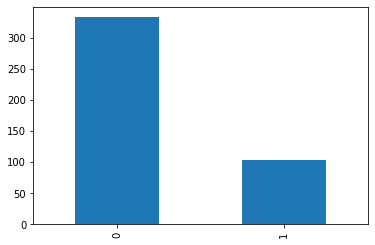

In [12]:
training_df.CAD.value_counts().plot.bar()

In [0]:
test_df = test.loc[:,('CAD','clean_text')]

In [14]:
test_df.CAD.value_counts()

0    192
1     64
Name: CAD, dtype: int64

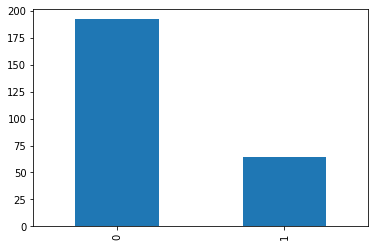

In [15]:
test_df.CAD.value_counts().plot.bar()

**1. Data precessing**

In [0]:
data_lm = TextLMDataBunch.from_df(train_df = training_df, valid_df = test_df, path = "")

In [17]:
data_lm.show_batch()

idx,text
0,marrow remain hypercellular persist low level blast novemb bone marrow biopsi show cellular xxunk space xxunk aml cell xxunk start due splenic pain patient admit decemb mani quot peripher blood stem cell transplant quot cours without major complic sinc discharg hospit one week ago twin graft stem cell poli white blood cell differenti also persist blast patient taken gmcsf splenic pain pain improv febril transfus sever occas white blood cell
1,one trial patient recent also left arm left facial swell underw mri show boni met left clavicl compress left subclavian vein receiv xrt xxunk patient start phase one trial patient notic increas leg swell sinc per oncologist start worsen also increas lft increas creatinin admiss normal hyperkalemia past two day treat kayexal fluid lab get wors underli process occur addit patient hypertens systol oncologist apo yesterday colon cancer per hpi
2,took place juli admit place dobutamin diures dri weight pound present least pound weight gain spite dose increas diuret also complain abdomin bloat report increas size abdomen deni fever chill sweat nausea vomit diarrhea chest pain mild short breath coronari diseas ischem cardiomyopathi hypertens urinari retent chronic indwel foley gout peripher vascular diseas basal cell carcinoma chronic renal insuffici zaroxolyn mg monday wednesday friday recent increas mg po bid ampicillin
3,heart failur histori hypertens peripher vascular diseas statu post left femor poplit bypass graft compet wound dehisc line sepsi recent secondari enterococcu klebsiella klebsiella bacteremia thought secondari infect cyst statu post excis right thigh av graft histori parathyroidectomi statu post carotid endarterectomi histori anemia statu post right femor av graft wound breakdown fungal sepsi secondari graft infect histori depress anxieti blood pressur heart rate respir left groin wound dress anicter
4,patient apo care becom appar mitral regurgit worsen also sourc sepsi found worsen mitral regurgit find sever mitral regurgit cardiac catheter well elev fill pressur everyon apo opinion patient would wait complet long cours antibiot accordingli taken oper room cardiac procedur sustain dissect ascend aorta therefor underw graft replac ascend aorta mitral valv replac valv excis materi appear infect debrid possibl clean area thoroughli also becam appar evid calcif around


In [18]:
# Listing below first 30 unique tokens in order of frequency

#xxbos: Begining of a sentence
#xxfld: Represent separate parts of a document like title, summary etc., each one will get a separate field and so they will get numbered (e.g. xxfld 1, xxfld 2).
#xxup: If there's something in all caps, it gets lower cased and a token called xxup will get added to it. Words that are fully capitalized, such as “I AM SHOUTING”, are tokenized as “xxup i xxup am xxup shouting“
#xxunk: token used instead of an uncommon word.
#xxmaj: token indicates that there is capitalization of the word. “The” will be tokenized as “xxmaj the“.
#xxrep: token indicates repeated word, if you have 29 ! in a row, (i.e. xxrep 29 !

data_lm.vocab.itos[:30]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'patient',
 'mg',
 'day',
 'left',
 'discharg',
 'right',
 'po',
 'pain',
 'normal',
 'blood',
 'time',
 'hospit',
 'show',
 'dr',
 'histori',
 'admiss',
 'follow',
 'well',
 'chest',
 'apo',
 'medic']

In [19]:
data_lm.train_ds[0][0].data[:10]

array([   2,  785, 1323,    0,  444,  801,  477,   46,   56,  334])

**2. Create language model**

a. use the pre-trained language model weights.

In [0]:
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
# drop_mult , a hyper-parameter ,used for regularization, sets the amount of dropout. 
# If the model is over-fitting increase it, if under-fitting, you can decrease the number.

b. Fine-tuning

In [26]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


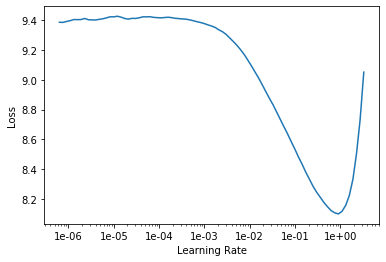

In [27]:
learner.recorder.plot()
#learning rate against loss and determine the lowest point (around 1e+00 for the plot below) 
# and go back by one magnitude and choose that as a learning rate (1e-01)

In [28]:
learner.fit_one_cycle(1,1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,6.830019,6.008559,0.157848,00:15


In [29]:
# unfreeze (unfreeze the whole model for training) and train the whole thing.
learner.unfreeze()

learner.fit_one_cycle(1,1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,5.441105,5.429977,0.196187,00:18


In [0]:
learner.save_encoder('ft_encoder')

In [31]:
learner.predict("Each element of the dataset is a tuple, where the first element is", n_words=3)

'Each element of the dataset is a tuple, where the first element is beceneigh unsuccess insulin'

In [32]:
learner.predict("This is a review about", n_words=5)

'This is a review about bmot ta xxbos puomc atyp'

**3. Creating the classifier**


create our classifier. Step one, is to create a data bunch, TextClasDataBunch, passing the vocab from the language model to make sure that this data bunch is going to have exactly the same vocab. Batch size bs to be used is according to the GPU memory you have available, for a 16GB GPU around bs=64 will work fine. You can find whatever batch size fits on your card and use it accordingly.

In [0]:
data_class = TextClasDataBunch.from_df(path = "", train_df = training_df, valid_df = test_df, vocab=data_lm.train_ds.vocab, bs=32)

In [34]:
classifier = text_classifier_learner(data_class, AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('ft_encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (437 items)
x: TextList
xxbos ctmc leukemia xxunk bone marrow transplant sign di new year day sign swatlleebtik telshey md phd mr xxunk year old man histori myelodysplast syndrom acut myelogen leukemia present day statu post nonmyeloabl peripher blood stem cell transplant admit fatigu neutropenia abnorm chest ray januari patient found anem monitor close start folic acid august bone marrow biopsi show md abnorm xxunk treat xxunk due increas number blast four treatment cycl marrow remain hypercellular persist low level blast novemb bone marrow biopsi show cellular xxunk space xxunk aml cell xxunk start due splenic pain patient admit decemb mani quot peripher blood stem cell transplant quot cours without major complic sinc discharg hospit one week ago twin graft stem cell poli white blood cell differenti also persist blast patient taken gmcsf splenic pain pain improv febril transfus sever occas white blood cell count platelet count note

In [35]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


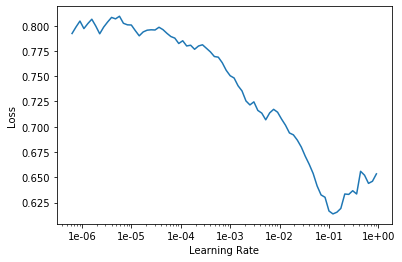

In [36]:
classifier.recorder.plot()

In [37]:
classifier.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.625809,0.558119,0.785156,00:16


In [38]:
classifier.fit_one_cycle(1, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.516465,0.510260,0.796875,00:15


In [39]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.483024,0.391764,0.882812,00:18


In [40]:
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.386291,0.284900,0.910156,00:23


In [41]:
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(1e-3/100, 1e-3),moms = (0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.322610,0.298717,0.894531,00:33


In [0]:
from fastai.vision import *

In [0]:
preds, y, losses = classifier.get_preds(with_loss = True)


In [0]:
interp =  ClassificationInterpretation(classifier, preds, y, losses)

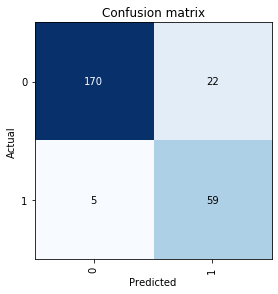

In [45]:
interp.plot_confusion_matrix()